In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from datetime import datetime

from feature_engineering import compute_ttfl

In [2]:
path_data = os.path.join(os.getcwd(), 'data', 'season_2018_cleaned.csv')
df = pd.read_csv(path_data)
df.head()

,name,date,mp,fg,fga,fg_pct,fg3,fg3a,fg3_pct,ft,...,blk_sn,tov_sn,pf_sn,pts_sn,plus_minus_sn,score_sn,opp_score_sn,last_game,record,opp_record
0,"Durant,Kevin",20190126,39,10,23,0.44,1,4,0.25,12,...,30.10,43.37,33.68,85.58,13.82,193.37,230.65,2.0,20,12
1,"Curry,Stephen",20190126,38,7,15,0.47,6,12,0.50,4,...,10.95,30.00,33.80,53.73,14.52,158.13,171.77,2.0,20,12
2,"Thompson,Klay",20190126,34,8,16,0.50,3,8,0.38,2,...,21.24,31.22,43.47,55.71,7.20,193.37,230.65,2.0,20,12
3,"Green,Draymond",20190126,34,1,3,0.33,1,2,0.50,2,...,17.22,27.25,39.88,23.91,11.43,134.93,163.12,2.0,20,12
4,"Cousins,DeMarcus",20190126,23,4,9,0.44,1,2,0.50,6,...,1.73,3.46,3.00,4.26,1.05,19.47,13.09,2.0,20,12


In [33]:
df['record'] = df.wins - df.losses

In [34]:
df_opp = df.copy()[['team', 'wins', 'losses', 'opp', 'date']]
df_opp['opp_record'] = df_opp['wins'] - df_opp['losses']
df_opp = df_opp.rename(columns={'team': 'opp', 'opp': 'team'})

df_opp = df_opp.drop_duplicates(subset=['opp', 'team', 'date', 'opp_record'])
df_opp.drop(columns=['wins', 'losses'], inplace=True)
df = df.merge(df_opp)
df = df.fillna(0)
for col in list(df.columns):
    col_no_inf = df[df[col] != np.inf][col].max()
    df[col] = df[col].replace(np.inf, col_no_inf)
    col_no_ninf = df[df[col] != -np.inf][col].min()
    df[col] = df[col].replace(-np.inf, col_no_ninf)

In [35]:
int_cols = list(df.dtypes[(df.dtypes == int)].index)
float_cols = list(df.dtypes[(df.dtypes == float)].index)
df[int_cols + float_cols] = df[int_cols + float_cols].round(2)

In [3]:
targets = ['fg', 'fga', 'fg3', 'fg3a', 'ft', 'fta', 'orb', 'drb', 'ast', 'stl', 'blk', 'tov', 'pts', ' trb']

In [4]:
regressions = {'fg': ['fg_lw', 'fg_pct_lw', 'fg3_lw', 'fg3_pct_lw', 'fga_lw', 'fg3a_lw', 'ft_lw', 'fta_lw', 
                      'fg_sn', 'fg_pct_sn', 'fg3_sn', 'fg3_pct_sn', 'fga_sn', 'fg3a_sn', 'ft_sn', 'fta_sn', 
                      'last_game', 'mp_lw', 'mp_sn', 'opp_record', 'record', 'plus_minus_lw', 'plus_minus_sn',
                      'pts_lw', 'pts_sn', 'score_lw', 'score_sn', 'orb_lw', 'orb_sn', 'tot_game'],
               
               'fga': ['fg_lw', 'fg_pct_lw', 'fg3_lw', 'fg3_pct_lw', 'fga_lw', 'fg3a_lw', 'ft_lw', 'fta_lw', 
                       'fg_sn', 'fg_pct_sn', 'fg3_sn', 'fg3_pct_sn', 'fga_sn', 'fg3a_sn', 'ft_sn', 'fta_sn',
                       'last_game', 'mp_lw', 'mp_sn', 'opp_record', 'record', 'plus_minus_lw', 'plus_minus_sn',
                       'pts_lw', 'pts_sn', 'score_lw', 'score_sn', 'tot_game'],
               
               'fg3': ['fg_lw', 'fg_pct_lw', 'fg3_lw', 'fg3_pct_lw', 'fga_lw', 'fg3a_lw', 'ft_lw', 'fta_lw', 
                      'fg_sn', 'fg_pct_sn', 'fg3_sn', 'fg3_pct_sn', 'fga_sn', 'fg3a_sn', 'ft_sn', 'fta_sn', 
                      'last_game', 'mp_lw', 'mp_sn', 'opp_record', 'record', 'plus_minus_lw', 'plus_minus_sn',
                      'pts_lw', 'pts_sn', 'score_lw', 'score_sn', 'orb_lw', 'orb_sn', 'tot_game'], 
               
               'fg3a': ['fg_lw', 'fg_pct_lw', 'fg3_lw', 'fg3_pct_lw', 'fga_lw', 'fg3a_lw', 'ft_lw', 'fta_lw', 
                       'fg_sn', 'fg_pct_sn', 'fg3_sn', 'fg3_pct_sn', 'fga_sn', 'fg3a_sn', 'ft_sn', 'fta_sn',
                       'last_game', 'mp_lw', 'mp_sn', 'opp_record', 'record', 'plus_minus_lw', 'plus_minus_sn',
                       'pts_lw', 'pts_sn', 'score_lw', 'score_sn', 'tot_game'], 
               
               'ft': ['fg_lw', 'fg_pct_lw', 'fg3_lw', 'fg3_pct_lw', 'fga_lw', 'fg3a_lw', 'ft_lw', 'fta_lw', 
                      'fg_sn', 'fg_pct_sn', 'fg3_sn', 'fg3_pct_sn', 'fga_sn', 'fg3a_sn', 'ft_sn', 'fta_sn', 
                      'last_game', 'mp_lw', 'mp_sn', 'opp_record', 'record', 'plus_minus_lw', 'plus_minus_sn',
                      'pts_lw', 'pts_sn', 'score_lw', 'score_sn', 'orb_lw', 'orb_sn', 'tot_game'], 
               
               'fta': ['fg_lw', 'fg_pct_lw', 'fg3_lw', 'fg3_pct_lw', 'fga_lw', 'fg3a_lw', 'ft_lw', 'fta_lw', 
                       'fg_sn', 'fg_pct_sn', 'fg3_sn', 'fg3_pct_sn', 'fga_sn', 'fg3a_sn', 'ft_sn', 'fta_sn',
                       'last_game', 'mp_lw', 'mp_sn', 'opp_record', 'record', 'plus_minus_lw', 'plus_minus_sn',
                       'pts_lw', 'pts_sn', 'score_lw', 'score_sn', 'tot_game'], 
               'pts': ['fg_lw', 'fg_pct_lw', 'fg3_lw', 'fg3_pct_lw', 'fga_lw', 'fg3a_lw', 'ft_lw', 'fta_lw', 
                      'fg_sn', 'fg_pct_sn', 'fg3_sn', 'fg3_pct_sn', 'fga_sn', 'fg3a_sn', 'ft_sn', 'fta_sn', 
                      'last_game', 'mp_lw', 'mp_sn', 'opp_record', 'record', 'plus_minus_lw', 'plus_minus_sn',
                      'pts_lw', 'pts_sn', 'score_lw', 'score_sn', 'orb_lw', 'orb_sn', 'tot_game', 'stl_lw', 
                       'stl_sn'],
              'ttfl': ['fg_lw', 'fg_pct_lw', 'fg3_lw', 'fg3_pct_lw', 'fga_lw', 'fg3a_lw', 'ft_lw', 'fta_lw', 
                      'fg_sn', 'fg_pct_sn', 'fg3_sn', 'fg3_pct_sn', 'fga_sn', 'fg3a_sn', 'ft_sn', 'fta_sn', 
                      'last_game', 'mp_lw', 'mp_sn', 'opp_record', 'record', 'plus_minus_lw', 'plus_minus_sn',
                      'pts_lw', 'pts_sn', 'score_lw', 'score_sn', 'orb_lw', 'orb_sn', 'tot_game', 'stl_lw', 
                       'stl_sn', 'tov_lw', 'tov_sn', 'drb_lw', 'drb_sn', 'blk_lw', 'blk_sn', 'ast_lw', 'ast_sn'],
              'tov': ['tov_sn', 'tov_lw', 'opp_record', 'opp_score_lw', 'pls_minus_sn', 'plus_minus_lw']}

In [7]:
not_ttfl_col = not_ttfl_col = list(set(df.columns) - set(targets) - set(['ttfl']))
cols = [col for col in list(not_ttfl_col) if 
        col.endswith('_sn') or col.endswith('lw')] + ['last_game', 'tot_game' , 'opp_record' , 'record']

In [8]:
def linear_regression(df, target, varbls):
    y = df[target]
    X = df[varbls]
    X = MinMaxScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    #training_score = model.score(X_train, y_train)
    #testing_score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    return y_test, y_pred

In [23]:
def linear_regression_ttfl(df, regressions):
    reg = {}
    for target in targets:
        if target != 'ttfl':
            reg[target] = linear_regression(df, target, targets)[0]
    ttfl_computed = compute_ttfl(reg, missed=False)
    return ttfl_computed

In [9]:
def cross_val(df, target, varbls):
    y = df[target]
    X = df[varbls]
    model = LinearRegression()
    res = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=5,
                          verbose=3, n_jobs=3)
    print(res)

In [19]:
res = {}
for target, varbls in regressions.items():
    reg = linear_regression(df, target, varbls)
    reg2 = linear_regression(df, target, cols)
    res[target] = np.sqrt(mean_absolute_error(reg[0], reg[1]), mean_absolute_error(reg2[0], reg2[1])
    print(target, res[target])

fg (2.0728505384308575, 2.070136241517258)
fga (3.515939977177071, 3.4946947896636127)
fg3 (0.9483091626596274, 0.950303219897758)
fg3a (1.796460903179771, 1.7906283465235016)
ft (1.5621718614358115, 1.5624715868431267)
fta (1.9213142407375123, 1.9226420556513808)
pts (5.366494440057399, 5.3618579911576285)
ttfl (8.379712492994267, 8.395235056840466)


In [5]:
def xgb_cv(df, target, varbls):
    y = df[target]
    X = df[varbls]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337)
    params = {
            'min_child_weight': [1, 3, 5],
            'gamma': [0.1, 0.2, 0.3, 0.4, 0.5],
            'subsample': [0.5, 0.55, 0.6],
            'colsample_bytree': [0.4, 0.5, 0.6],
            'max_depth': [3, 4, 5],
            'reg_alpha': [0.25, 0.5, 0.75, 1.0, 1.25],
            'reg_lambda': [0.8, 0.85, 0.9],
            'learning_rate': [0.1, 0.15, 0.2]
            }

    xgb_reg = xgb.XGBRegressor(objective = 'reg:squarederror',
                               n_estimators = 200)
    folds = 5
    param_comb = 10

    skf = KFold(n_splits=folds, shuffle = True, random_state = 1001)

    random_search = RandomizedSearchCV(xgb_reg, param_distributions=params, 
                                       n_iter=param_comb, scoring='neg_median_absolute_error',
                                       n_jobs=4, cv=skf.split(X_train,y_train), 
                                       verbose=3, random_state=1001)

    # Here we go
    # timing starts from this point for "start_time" variable
    random_search.fit(X_train, y_train)
    # timing ends here for "start_time" variable
    preds = random_search.predict(X_test)
    mae = (mean_absolute_error(y_test, preds))
    bp = random_search.best_params_
    
    return mae, bp

In [8]:
res = xgb_cv(df, 'ttfl', cols)
print(res)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  4.4min finished
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


NameError: name 'target' is not defined

In [9]:
X = df[cols]
y = df['ttfl']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337)
model_xgb = xgb.XGBRegressor(n_estimators=2200,
                             random_state =7, nthread = -1, **res[1])
model_xgb.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:08:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.2,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=2200,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=7,
             reg_alpha=0.25, reg_lambda=0.8, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.55, verbosity=1)

In [11]:
preds = model_xgb.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds))

10.730848342273694

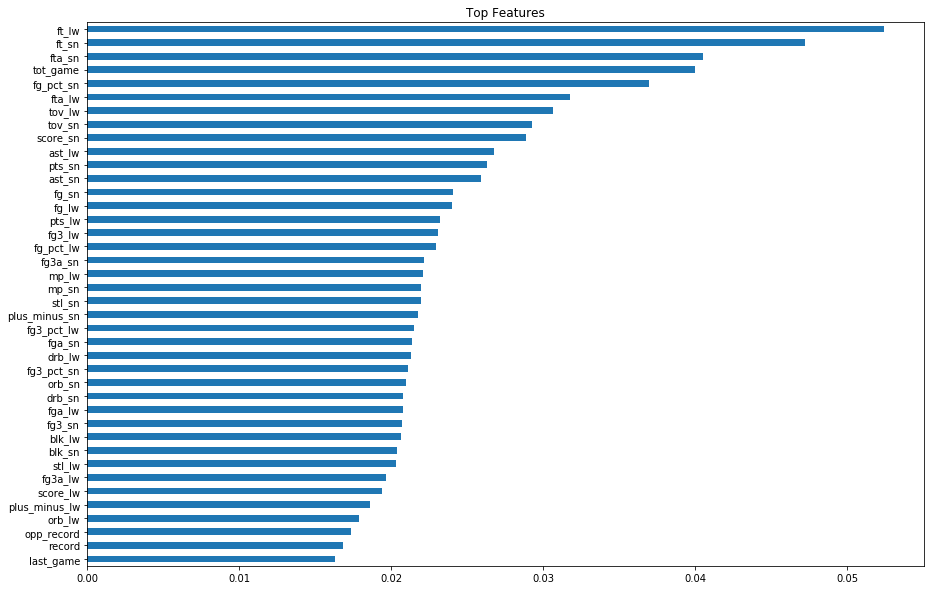

In [244]:
pd.Series(model_xgb.feature_importances_, index = varbls).sort_values().plot(kind = "barh", figsize=(15,10) ,title='Top Features')
plt.show()

In [ ]:
class xgb():
    def __init__(self):
        self